# Identification of Factors Generating Time and Cost Deviation in Competitive Bids for Construction Rural Roads in Colombia

The purpose of this notebook is to present the data analysis workflow that allows identifying the factors that generate deviations in time and cost in tenders for construction projects of rural roads in Colombia, from the open data of public contracting registered in the SECOP I platform. This is part of the doctoral thesis *[Identification of Factors Generating Time and Cost Deviation in Construction Projects: a Case Study in Rural Roads in Colombia](https://repositorio.uniandes.edu.co/handle/1992/52996)* by [Adriana Gomez](https://ingenieria.javeriana.edu.co/w/facultad-de-ingenierÍa-profesores-civil?redirect=%2Fcuerpo-docente). 

The data anlytics process is divided in four phases:

- Definition of target projects and data collection.
- Exploratory data analysis.
- Identification and analysis of significant factors for time and cost deviations.
- Identification of significant factors in variables transformed to categorical variables.

![](images/detailed-research-method.png)

## 1. Definition of target projects and data collection (ETL)

The acquisition and processing of the data is carried out following the ETL process:
- __Extract:__ selection of rural road construction contract records from the SECOP I database.
- __Transform:__ processing, standardization and cleaning data of the selected contracts.
- __Load:__ transformation of the extracted data and consolidation in a master table.

![](images/ETL.png)

__Electronic Public Procurement System in Colombia__

The data for the study were obtained from the database of the _Electronic Public Procurement System (Sistema Electrónico de Contratación Pública SECOP)_. This system is managed by the National Public Procurement Agency. For the registration and management of contracting processes, there are two systems: SECOP I and SECOP II. The first is the oldest version of the system and is used only for registering contracts. The second is a transactional system in which purchases, contracts, tenders, auctions are managed.

For this study, the SECOP I database was taken, which is composed of a series of tables containing information on the contracting processes, the additions to the contracts, the annual acquisition plans of the entities, the fines and sanctions and the providers of the processes. For the research, the Contracting Processes table was taken. This table contains a total of 73 attributes which includes information on:

- The public entity (Id, name, level, order, location)
- The contracting process (regime, type of process, state, ID)
- The object of the contract (type of contract, object, classification of the object according to the UNSPSC catalogue)
- Contract value (process value, contract value, additions, currency)
- Date and deadlines 
- Contractor (ID, company name, legal representative, location)
- Others

### 1.1 Data acquisition (Extract)

The SECOP I data acquisition process is divided into two parts:

- _Extraction of structured data:_ it is done through a query where filters are applied that allow selecting the contracts (rows) and attributes (columns).
- _Extraction of unstructured data:_ with the inventory of contracts selected in the extraction of structured data, a search is made for information of interest that is contained in the documentation of the contracts.

Each of these steps is described in more detail below.

#### 1.1.1 Structured Data Acquisition
 
The criteria used for the selection of attributes and contracts are described below:
 
__Selection of attributes (columns)__
 
Based on the research questions, the contract attributes to be analyzed are selected:
 
- Entity information: name of the entity, order and level of entity, geographic location (department and municipality).
- Contracting process: system and type of contracting process
- Object of the contract: classification of the object and detail of the object
- Value of the contract: amount of the process, amount of the contract, additions in the amount and total value with additions
- Dates and terms of the contract: signature date, start and end date, execution period and time additions
 
__Selection of contracts (rows)__
 
Taking into account that the research is focused on rural roads, the filters applied to the data are listed below:
 
- Contract signing date: between 2014 and February 2020
- Type of contract: _obra_, family code = 9511 (according to UNSPSC classification)
- Amount of the process and the contract: >= $20,000,000
- Contract regime: special regime contracts are excluded
- Type of process: only competitive processes were included (only tenders)
- Contract status: only completed and settled contracts are included
- Object of the contract: contracts whose object includes terms such as: suministro de mezcla asfáltica; señalización horizontal; construcción de reductores de velocidad, barandas, muros de contención; demolición; restauración estación férrea; señalización; rehabilitación y conservación puente; mantenimiento túnel; alcantarilla; mano de obra; Box culvert; puentes colgantes; casco urbano; vías urbanas; ejercito; semaforización; demoliciones; muro; ciclovias o cicloruta; residuos sólidos; desmonte y limpieza; y aulas.

#### 1.1.2 Adquisición de datos no estructurados

Much of the information for contract planning, process design, and bid evaluation is not structured and stored in tables. For this reason, from the selected contracts, a manual search of the information was carried out in documents such as: specifications, evaluation reports, contracts and contract modification documents. The variables extracted from these documents are listed below.

For the project initiation phase, two variables:

- Time studies contract
- IDI: Integral performance index for municipalities

For the project planning phase, seventeen new variables related to the contractual process:

- Advanced payment
- Experience
- Contracting capacity
- Liquidity index
- Debt index
- Interest coverage ratio 
- ROE
- ROA
- Working capital
- Net equity
- Number of bidders

This phase also included four additional variables related to the qualification of the bidders, consisting of the percentage assigned to each of the four aspects allowed by Colombian law (Decreto 1510 de 2013 - EVA - Función Pública, 2013):

- Technical score
- Price score
- National industry score
- Other score

This phase included two additional variables considering the category for which the highest and the lowest scores were assigned in the bidding:

- Lowest score
- Highest score

Finally, the project execution adds one new variable:
- Time suspended.

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

ETL is a python module that contains functions to extract the structured data directly from SECOP I and transform it according to the tasks defined in section 1.1.1

In [123]:
# Extraer datos del SECOP
from ETL import extract_data, process_data

Next, a part of the raw data extracted from SECOP I is presented.

In [124]:
raw_data = extract_data()
raw_data.head()

El numero de contratos extraidos: 790


,uid,nombre_de_la_entidad,departamento_entidad,orden_entidad,tipo_de_proceso,objeto_a_contratar,detalle_objeto,cuantia_proceso,cuantia_contrato,valor_total_de_adiciones,valor_contrato_con_adiciones,anno_firma,fecha_fima,fecha_ini_ejec_contrato,plazo_de_ejec_del_contrato,rango_de_ejec_del_contrato,tiempo_adiciones_en_dias,tiempo_adiciones_en_meses,fecha_fin_ejec_contrato
0,15-1-1488216430156,VALLE DEL CAUCA ALCALDÍA MUNICIPIO DE LA UNIÓN,Valle del Cauca,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Licitación Pública,"Terrenos, Edificios, Estructuras y Vías",CONSTRUCCION DE PAVIMENTO RIGIDO EN LA CL 13 C...,285341776,285151179,0,285151179,2015,2015-11-18,2015-12-14,60,D,30,0,2016-03-13 00:00:00
1,15-1-1445654095917,ANTIOQUIA ALCALDÍA MUNICIPIO DE MEDELLÍN,Antioquia,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,Licitación Pública,"Terrenos, Edificios, Estructuras y Vías",CONFORMACIÓN PARCHEO PAVIMENTACIÓN REPAVIMENTA...,1779588615,1750717720,0,1750717720,2015,2015-10-09,2015-11-03,3,M,0,0,2016-02-03 00:00:00
2,18-21-74068240139,CASANARE ALCALDÍA MUNICIPIO DE SABANALARGA,Casanare,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Licitación obra pública,"Terrenos, Edificios, Estructuras y Vías",REALIZAR LA CONSTRUCCIÓN DE OBRAS DE DRENAJE Y...,279116919,279010379,44271346,323281725,2019,2019-02-01,2019-02-01,4,M,15,0,2019-06-01 00:00:00
3,17-1-1792116571655,CAQUETÁ ALCALDÍA MUNICIPIO DE CARTAGENA DEL C...,Caquetá,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 6,Licitación Pública,"Terrenos, Edificios, Estructuras y Vías",EJECUCION DEL PROGRAMA DE RED DE VIAS TERCIARI...,878217589,878217589,0,878217589,2017,2017-10-18,2017-10-20,2,M,248,0,2018-08-20 00:00:00
4,20-1-21221310564001,SANTANDER ALCALDÍA MUNICIPIO DE SANTA BÁRBARA,Santander,TERRITORIAL DISTRITAL MUNICIPAL NIVEL 2,Licitación Pública,"Terrenos, Edificios, Estructuras y Vías",PAVIMENTACIÓN Y MEJORAMIENTO PARA LA VIALIDAD ...,520000000,503956626,240000000,743956626,2020,2020-12-02,2020-12-14,4,M,0,3,2021-07-14 00:00:00


### 1.2 Transformation, standardization and cleaning of data (Transform)
 
The transformation, standardization and cleaning tasks seek to modify the variables in such a way that concepts are unified, correct data formats according to type, group categories of nominal variables, which facilitates data analysis and management. New variables are also created in this part in order to extract new information and patterns from existing data. The applied tasks are described below:

#### 1.2.1 Transformación y estandarización 

- Duration of the contract in days: in the original database you can find the duration of the contract in days or months. To facilitate the analysis, the duration in days was unified.
- Scaling the value of the contracts: to include the inflation factor in the contracts, these were scaled based on the monthly minimum wage in Colombia -SMMLV- according to the year of signing the contract. This transformation was applied to the amount of the process, amount of the contract, additions in the amount, total value with additions.
- Standardize date formats in the year-month-day structure (YYYY-MM-DD)
- Standardize the order of the entity: a category was assigned according to the municipality of the entity. This classification is established by the national planning department (Departamento de Planeación Nacional DNP) according to the number of inhabitants and their income.
- Intensity of the project: a variable is created that relates the value of the contract and the duration.
- Award Growth: a variable is created to estimate the relationship between the value of the winning offer and the base price established for the tender.
- Classify the entities by region: according to the department of the entity, it was assigned to one of the five regions of Colombia.
- Contract suspension: a variable is created that indicates the duration of the contract suspension as a percentage of the estimated duration.
- Deviation in cost and deviation in time: two output variables associated with deviations in cost and time were created for each of the contracts. For this, the following formulas were used:
 
$$
\text{Time Deviation} = \frac{\text{Final Deadline - Original Deadline}}{\text{Original Deadline}}
$$

$$
\text{Cost Deviation} = \frac{\text{Final Cost - Contract Value}}{\text{Contract Value}}
$$

Next, the processed data is presented.

In [125]:
proc_data = process_data(raw_data)
proc_data.head()

,CONTRACT_ID,ENTITY_NAME,DEPARTMENT,MUNICIPALITY_TYPE,PROCESS_TYPE,CONTRACT_OBJECT,OBJETC_DETAIL,ESTIMATED_COST,CONTRACT_VALUE,ADDITIONAL_COST,FINAL_COST,YEAR,CONTRACT_DATE,START_DATE,ORIGINAL_DEADLINE,END_DATE,ADDITIONAL_TIME,FINAL_DEADLINE,PROJECT_INTENSITY,AWARD_GROWTH,COST_DEVIATION,TIME_DEVIATION,OWNER,REGION
0,15-1-1488216430156,VALLE DEL CAUCA ALCALDÍA MUNICIPIO DE LA UNIÓN,VALLE DEL CAUCA,TYPE_6,LICITACIÓN PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",CONSTRUCCION DE PAVIMENTO RIGIDO EN LA CL 13 C...,442.836620,442.540823,0.000000,442.540823,2015,2015-11-18,2015-12-14,60,2016-03-13,30,90,7.375680,-0.066796,0.000000,0.500000,MUNICIPALITY,PACIFICA
1,15-1-1445654095917,ANTIOQUIA ALCALDÍA MUNICIPIO DE MEDELLÍN,ANTIOQUIA,TYPE_2,LICITACIÓN PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",CONFORMACIÓN PARCHEO PAVIMENTACIÓN REPAVIMENTA...,2761.835361,2717.029130,0.000000,2717.029130,2015,2015-10-09,2015-11-03,90,2016-02-03,0,90,30.189213,-1.622335,0.000000,0.000000,MUNICIPALITY,ANDINA
2,18-21-74068240139,CASANARE ALCALDÍA MUNICIPIO DE SABANALARGA,CASANARE,TYPE_6,LICITACIÓN OBRA PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",REALIZAR LA CONSTRUCCIÓN DE OBRAS DE DRENAJE Y...,337.050509,336.921855,53.460320,390.382175,2019,2019-02-01,2019-02-01,120,2019-06-01,15,135,2.807682,-0.038170,0.158673,0.125000,MUNICIPALITY,ORINOQUIA
3,17-1-1792116571655,CAQUETÁ ALCALDÍA MUNICIPIO DE CARTAGENA DEL C...,CAQUETÁ,TYPE_6,LICITACIÓN PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",EJECUCION DEL PROGRAMA DE RED DE VIAS TERCIARI...,1190.453235,1190.453235,0.000000,1190.453235,2017,2017-10-18,2017-10-20,60,2018-08-20,248,308,19.840887,0.000000,0.000000,4.133333,MUNICIPALITY,AMAZONIA
4,20-1-21221310564001,SANTANDER ALCALDÍA MUNICIPIO DE SANTA BÁRBARA,SANTANDER,TYPE_2,LICITACIÓN PÚBLICA,"TERRENOS, EDIFICIOS, ESTRUCTURAS Y VÍAS",PAVIMENTACIÓN Y MEJORAMIENTO PARA LA VIALIDAD ...,592.388042,574.111305,273.409865,847.521170,2020,2020-12-02,2020-12-14,120,2021-07-14,90,210,4.784261,-3.085264,0.476231,0.750000,MUNICIPALITY,ANDINA


#### 1.2.2 Reviewing data quality

Some basic aspects to review to ensure data quality are:
- Duplicates
- Missing data
- Validity and consistency
     - Consistency in dates: Completion date < start date < signature date
     - Law restrictions on additions: Deviation in cost must be less than 50%
     - *Legal restrictions on the duration and values of the contracts*
- Mistakes
     - Amounts and additions in value
     - Deadlines and additions on time
     - Currency
     - Object
     - Classification of the contract

## 1.3 Consolidation of the data in a master table (Load)

All the data is consolidated in a master table, which contains all the transformed variables that will be used in the data analysis and the development of the models. A description of the attributes in this database is presented below:

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#9ABAD9;border-spacing:0;}
.tg td{background-color:#EBF5FF;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#444;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#409cff;border-color:#9ABAD9;border-style:solid;border-width:1px;color:#fff;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-cly1{text-align:left;vertical-align:middle}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-cly1">Phase</th>
    <th class="tg-cly1">Variable</th>
    <th class="tg-cly1">Type</th>
    <th class="tg-cly1">Description</th>
    <th class="tg-cly1">Unit/Values</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax" rowspan="10"> 			<br>Project initiation  		</td>
    <td class="tg-0lax"> 			<br>Project type 		</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax"> 			<br>The main project object.  		</td>
    <td class="tg-0lax"> 			<br>Construction or Maintenance  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Owner</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The entity or the stakeholder responsible for contracting the project. </td>
    <td class="tg-0lax">Amazonia, Andina, Caribe, Orinoquia, or Pacifica </td>
  </tr>
  <tr>
    <td class="tg-0lax">Geographic Location/ Region </td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">Colombian regions where the project takes place. </td>
    <td class="tg-0lax">Municipality or Other </td>
  </tr>
  <tr>
    <td class="tg-0lax">Municipality Type </td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">Class stated by Colombian law. (According to their number of inhabitants and income).</td>
    <td class="tg-0lax">Type 1 to 6, 1 being the highest category </td>
  </tr>
  <tr>
    <td class="tg-0lax">Period/ Year </td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The period of project execution, in this case, was established in years. </td>
    <td class="tg-0lax">Years: 2015, 2016, 2017, or 2018 </td>
  </tr>
  <tr>
    <td class="tg-0lax">Estimated Cost</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Budgeted construction cost, determined at the time of procurement by the owner. </td>
    <td class="tg-0lax">Minimum salaries </td>
  </tr>
  <tr>
    <td class="tg-0lax">Original Deadline</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The project planned duration, determined at the time of procurement by the owner.</td>
    <td class="tg-0lax">Days </td>
  </tr>
  <tr>
    <td class="tg-0lax">Project Intensity </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The ratio between the estimated cost and the original deadline. </td>
    <td class="tg-0lax">Minimum salaries/days </td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Time studies contract 		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>Number of days between the publication of previous studies and the signing of the contract 		</td>
    <td class="tg-0lax"> </td>
  </tr>
  <tr>
    <td class="tg-0lax">IDI </td>
    <td class="tg-0lax">N/A</td>
    <td class="tg-0lax">“Indice de Desempeño Integral”: calculated to evaluate public management and decision-making in the use of municipal resources for each municipality in Colombia </td>
    <td class="tg-0lax"> </td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="21"> 			<br>Project planning  		</td>
    <td class="tg-0lax"> 			<br>Process Type  		</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax"> 			<br>Modality chosen for the contractor procurement and selection.  		</td>
    <td class="tg-0lax"> 			<br>Competitive Bidding, Abbreviated Selection, Minimum Contract  Minimum salaries  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Contractor</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The stakeholder responsible for executing the project.</td>
    <td class="tg-0lax">Individual, Consortium, or Companies</td>
  </tr>
  <tr>
    <td class="tg-0lax">Contract Value</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The contract awarded amount. </td>
    <td class="tg-0lax">Minimum salaries </td>
  </tr>
  <tr>
    <td class="tg-0lax">Award Growth </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The ratio between the difference of contract value and the estimated cost. </td>
    <td class="tg-0lax">Percentage (%) </td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Advanced payment 		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>Percentage of the initial cost paid before the start of the project  		</td>
    <td class="tg-0lax"> 			<br>Percentage  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Experience</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Value of required executed contracts expressed at present value</td>
    <td class="tg-0lax">--</td>
  </tr>
  <tr>
    <td class="tg-0lax">Contracting capacity (K)</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The bidder's capacity to perform the contract, taking into account other projects under execution. </td>
    <td class="tg-0lax">--</td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Liquidity index 		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>Current assets over current liabilities  		</td>
    <td class="tg-0lax"> 			<br>--  		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Debt index</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Total liabilities over total assets </td>
    <td class="tg-0lax">-- </td>
  </tr>
  <tr>
    <td class="tg-0lax">Interest coverage ratio</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Earnings before interest and taxes over interest expense</td>
    <td class="tg-0lax">-- </td>
  </tr>
  <tr>
    <td class="tg-0lax">Return on Equity – ROE</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Net income by shareholder's equity </td>
    <td class="tg-0lax">-- </td>
  </tr>
  <tr>
    <td class="tg-0lax">Return on Assets – ROA</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The ratio between net income and the average total assets.</td>
    <td class="tg-0lax"> </td>
  </tr>
  <tr>
    <td class="tg-0lax">Working capital</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Current Assets – Current Liabilities </td>
    <td class="tg-0lax">Cash </td>
  </tr>
  <tr>
    <td class="tg-0lax">Net equity</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Total Assets−Total Liabilities </td>
    <td class="tg-0lax">Cash </td>
  </tr>
  <tr>
    <td class="tg-0lax">Number of bidders</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Number of bidders participating in the hiring process</td>
    <td class="tg-0lax">Number of bidders</td>
  </tr>
  <tr>
    <td class="tg-0lax">Price score</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to price in the evaluation </td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">Technical score</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to technical aspects in the evaluation</td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">National industry</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to national industry score in the evaluation </td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">Other score</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">The percentage assigned to other aspects in the evaluation</td>
    <td class="tg-0lax">Percentage </td>
  </tr>
  <tr>
    <td class="tg-0lax">Lowest category score</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The category to which the lowest score has been assigned </td>
    <td class="tg-0lax">Price, technical, national industry, other</td>
  </tr>
  <tr>
    <td class="tg-0lax">Higher category score</td>
    <td class="tg-0lax">Categorical</td>
    <td class="tg-0lax">The category to which the highest score has been assigned</td>
    <td class="tg-0lax">Price, technical, national industry, other </td>
  </tr>
  <tr>
    <td class="tg-0lax" rowspan="5"> 			<br>Project execution and closure  		</td>
    <td class="tg-0lax"> 			<br>Additional Cost (Numerical)  		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax"> 			<br>The difference between the contract value and the final contract cost.  		</td>
    <td class="tg-0lax"> 			<br>Minimum salaries 		</td>
  </tr>
  <tr>
    <td class="tg-0lax">Additional Time (Numerical) </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Difference between the original deadline and the final contract deadline.</td>
    <td class="tg-0lax">Days </td>
  </tr>
  <tr>
    <td class="tg-0lax">Final Cost (Numerical)</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Final contract cost. </td>
    <td class="tg-0lax">Minimum salaries Days </td>
  </tr>
  <tr>
    <td class="tg-0lax">Final Deadline (Numerical) </td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Final contract deadline. </td>
    <td class="tg-0lax">Days </td>
  </tr>
  <tr>
    <td class="tg-0lax"> 			<br>Time suspended  		</td>
    <td class="tg-0lax">Numerical</td>
    <td class="tg-0lax">Number of days the project was suspended, expressed as a percentage of the initial deadline </td>
    <td class="tg-0lax">Percentage </td>
  </tr>
</tbody>
</table>

In [126]:
master_data = pd.read_excel('data/master_data.xlsx')
master_data['NUMBER_OF_CONTRACTS'] = [i for i in range(1, len(master_data) + 1)]
master_data.set_index('NUMBER_OF_CONTRACTS', inplace=True)
master_data.head()

,COST_DEVIATION,TIME_DEVIATION,TIME_STUDIES_CONTRACT,ADVANCED_PAYMENT,ESTIMATED_COST,ORIGINAL_DEADLINE,LIQUIDITY_INDEX_B,DEBT_INDEX_B,INTEREST_COVERAGE_RATIO_B,ROE_B,ROA_B,WORKING_CAPITAL,NET_EQUITY,EXPERIENCE_B_VALUE,K_CONTRACTING_B_VALUE,PROJECT_INTENSITY,PRICE_SCORE,TECHNICAL_SCORE,NATIONAL_INDUSTRY_SCORE,OTHER_SCORE,NUMBER_BIDDERS,CONTRACT_VALUE,AWARD_GROWTH,ADDITIONAL_COST,FINAL_COST,ADDITIONAL_TIME,FINAL_DEADLINE,TIME_SUSPENDED_P,IDI,CONTRACTOR,HIGHEST SCORE,LOWEST_SCORE,YEAR,IDI_CAT,CONTRACT_TYPE,MUNICIPALITY_TYPE,DEPARTMENT,REGION,REGION_2,OWNER,PERFORMANCE
NUMBER_OF_CONTRACTS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.18,0.50,111.0,0.0,861.08,90,10.0,0.50,1.0,0.05,0.02,1.00,NaN,2.14,0.54,9.57,0.50,0.20,0.10,0.20,1,861.07,-0.0018,153.74,1014.81,45,135,0.69,76.13,INDIVIDUAL,PRICE,NATIONAL_INDUSTRY,Y_2016,SATISFACTORY,CONSTRUCTION,TYPE_6,MAGDALENA,CARIBE,CARIBE,MUNICIPALITY,BOTH
2,0.25,0.00,38.0,0.0,325.26,90,85.0,0.16,85.0,0.13,0.11,NaN,NaN,3.01,1.00,3.61,0.38,0.50,0.06,0.06,1,325.26,-0.0013,81.32,406.57,0,90,0.00,72.85,INDIVIDUAL,TECHNICAL,OTHER,Y_2017,SATISFACTORY,MAINTEINANCE,TYPE_6,BOYACA,ANDINA,CENTRO_ORIENTE,MUNICIPALITY,COST_DEVIATION
3,0.00,0.38,41.0,0.4,1084.43,120,10.0,0.40,10.0,0.15,0.15,3.00,3.0,11.07,1.00,9.04,0.50,0.40,0.10,0.00,1,1084.43,0.0000,0.00,1084.43,45,165,0.00,80.47,COMPANY,PRICE,OTHER,Y_2017,OUTSTANDING,MAINTEINANCE,TYPE_6,ANTIOQUIA,ANDINA,EJE_CAFETERO,MUNICIPALITY,TIME_DEVIATION
4,0.00,0.00,47.0,0.0,358.75,60,25.0,0.50,4.0,0.55,0.30,NaN,NaN,1.00,1.00,5.98,0.60,0.30,0.10,0.00,1,358.42,-0.0892,0.00,358.42,0,60,0.00,47.26,CONSORTIUM,PRICE,OTHER,Y_2018,LOW,MAINTEINANCE,TYPE_6,TOLIMA,ANDINA,CENTRO_SUR,MUNICIPALITY,NO_DEVIATION
5,0.00,0.00,35.0,0.0,2020.64,60,250.0,0.15,5.0,0.10,0.10,0.99,NaN,1.00,0.44,33.68,0.27,0.61,0.04,0.08,1,2020.62,-0.0012,0.00,2020.62,0,60,1.28,74.50,CONSORTIUM,TECHNICAL,NATIONAL_INDUSTRY,Y_2015,SATISFACTORY,MAINTEINANCE,TYPE_6,BOYACA,ANDINA,CENTRO_ORIENTE,MUNICIPALITY,NO_DEVIATION


In [127]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 204
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COST_DEVIATION             204 non-null    float64
 1   TIME_DEVIATION             204 non-null    float64
 2   TIME_STUDIES_CONTRACT      203 non-null    float64
 3   ADVANCED_PAYMENT           204 non-null    float64
 4   ESTIMATED_COST             204 non-null    float64
 5   ORIGINAL_DEADLINE          204 non-null    int64  
 6   LIQUIDITY_INDEX_B          204 non-null    float64
 7   DEBT_INDEX_B               204 non-null    float64
 8   INTEREST_COVERAGE_RATIO_B  198 non-null    float64
 9   ROE_B                      201 non-null    float64
 10  ROA_B                      201 non-null    float64
 11  WORKING_CAPITAL            95 non-null     float64
 12  NET_EQUITY                 57 non-null     float64
 13  EXPERIENCE_B_VALUE         197 non-null    float64

## 2. Development of Exploratory Data Analysis

Exploratory data analysis aims to understand the data through statistics, graphs, correlation analysis and the identification of some problems such as missing data and outliers. From this, new data processing and cleaning tasks are developed.

### 2.1 Getting data profile (Pandas profiling)

A first full exploratory analysis can be performed with the help of the Pandas Profiling library. This allows the development of a standardized and fairly complete report that can be the basis for starting an exploratory data analysis. The report is generated in HTML format and can be viewed in a web browser. It contains the following parts:

- Analysis by column through statistics and graphs
- Correlation analysis between all pairs of variables
- Analysis of interaction between variables
- Missing values

In [128]:
#from pandas_profiling import ProfileReport

In [129]:
# Generate a report
#profile = ProfileReport(master_data, title="Pandas Profiling Report")

In [130]:
# Save the report in html format
#profile.to_file("pandas_profiling_report.html")

### 2.2 Missing data

Regarding the completeness of the data, different requirements of the contracting process were identified that are not mandatory in all the bidding processes. See the next Table where _Net equity_ and _Working capital_ with many missing data were not considered in further analysis. These factors are not requested in all bidding processes.

In [131]:
# count missing values
missing_data = (master_data
                .isnull()
                .sum()
                .sort_values(ascending=False)
                .reset_index()
                .rename(columns={'index': 'Variable', 0: 'Count'})
                .query("Count > 0")
                .assign(Porcentaje=lambda x: np.round(((x.Count / master_data.shape[0]) * 100), 2))
                )
missing_data

,Variable,Count,Porcentaje
0,NET_EQUITY,147,72.06
1,WORKING_CAPITAL,109,53.43
2,K_CONTRACTING_B_VALUE,9,4.41
3,EXPERIENCE_B_VALUE,7,3.43
4,INTEREST_COVERAGE_RATIO_B,6,2.94
5,ROE_B,3,1.47
6,ROA_B,3,1.47
7,TIME_STUDIES_CONTRACT,1,0.49


The variables with more than 50% missing values are removed.


In [132]:
master_data.drop(['NET_EQUITY', 'WORKING_CAPITAL'], axis=1, inplace=True)

The remaining variables with missing values are filled with the median.

In [133]:
master_data.fillna(master_data.median(), inplace=True)

/var/folders/yb/73r2f0hj06z2_w4y40669q480000gn/T/ipykernel_17087/46894491.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  master_data.fillna(master_data.median(), inplace=True)


### 2.3 Outliers Analysis (PCA - Kmeans)


To identify the outliers, the following steps were developed:
- Variables removed: CONTRACT_VALUE, FINAL_COST, ROA_B, FINAL_DEADLINE, NET_EQUITY, WORKING_CAPITAL (why?)
- Removed categorical variables
- A cluster analysis was carried out with the Kmeans method and 5 clusters were identified
- To visualize the clusters, an analysis of principal components was made.
- Clusters and contracts were identified that are significantly different from the majority of contracts

In [134]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

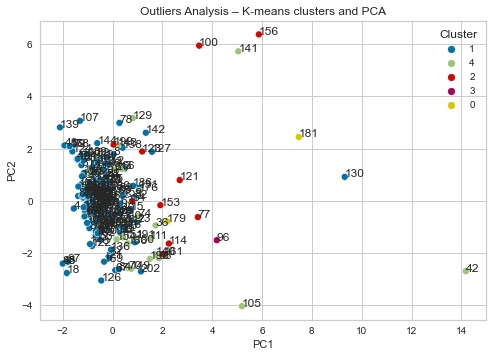

In [135]:
# Create a copy of master_data
master_data_filtered = master_data.copy()

# Delete columns -CONTRACT_VALUE,-FINAL_COST,-ROA_B,-FINAL_DEADLINE,-NET_EQUITY,-WORKING_CAPITAL
master_data_filtered = master_data_filtered.drop(['CONTRACT_VALUE', 'FINAL_COST', 'ROA_B', 'FINAL_DEADLINE'], axis=1)

# Select columns with numeric values
master_data_filtered = master_data_filtered.select_dtypes(include=['number'])

# Delete rows with missing values
master_data_filtered = master_data_filtered.dropna(axis=0)

# cluster with KMeans with data filtered
kmeans = KMeans(n_clusters=5, random_state=0).fit(master_data_filtered)
clusters = kmeans.labels_

pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=2))

# PCA with 2 components
#pca_model = PCA(n_components=2, whiten=True)
pca_data = pipe_pca.fit(master_data_filtered).transform(master_data_filtered)

# convert to pandas dataframe
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'], index=master_data_filtered.index)
pca_data['Cluster'] = [str(i) for i in clusters]

# plot pca with clusters colors
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_data)

# add text from index
for i in pca_data.index:
    plt.annotate(i, (pca_data.loc[i, 'PC1'], pca_data.loc[i, 'PC2']))
plt.title('Outliers Analysis – K-means clusters and PCA')
plt.show()

In the outlier analysis graph, a series of contracts can be identified that are significantly far from the majority of data, these are contracts: 42, 100, 105, 130, 141, 156 and 181. These data are removed from the sample, leaving 197 contracts.

In [136]:
# delete rows in outlier_index
oulier_index = [142, 100, 105, 130, 141, 156, 181]
master_data = master_data.loc[~master_data.index.isin(oulier_index),].copy()
print(master_data.shape)

(197, 39)


### 2.4 Correlations treatment 

The correlation analysis was included in a matrix, calculating the Spearman’s $\rho$. The higher the intensity of the color, the higher the correlation. Most researchers use a cutoff of 0.80 for identifying highly correlated variables [(Berry & Feldman, 1985)](https://books.google.com.co/books/about/Multiple_Regression_in_Practice.html?id=tbNWi_KjJ-sC&redir_esc=y) and [(Yoo et al., 2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4318006/), which was established.

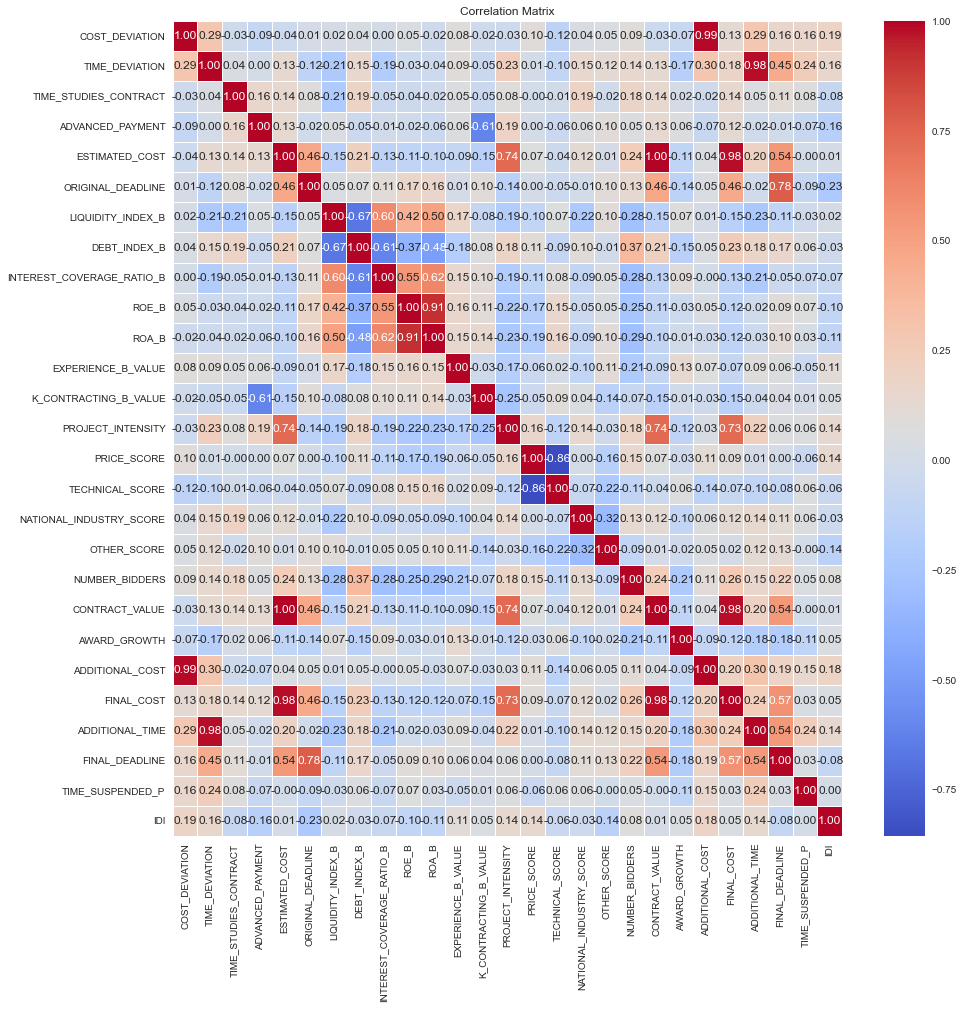

In [137]:
corr_matrix = master_data.corr(method='spearman')
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [138]:
num_cols = master_data.select_dtypes(include=['number']).columns
correlations = []
for i in range(len(num_cols)-1):
    for j in range(i+1, len(num_cols)):
        col_i = num_cols[i]
        col_j = num_cols[j]
        rho, pval = stats.spearmanr(master_data[col_i], master_data[col_j], nan_policy='omit')
        temp = (col_i, col_j, rho, pval)
        correlations.append(temp)

correlations = pd.DataFrame(correlations, columns=['Var1', 'Var2', 'rho', 'p-value'])

The variables whose correlation is greater than 0.8 are:

- ESTIMATED_COST and CONTRACT_VALUE with $\rho = 0.999945$
- COST_DEVIATION and ADDITIONAL_COST with $\rho = 0.988513$ 
- TIME_DEVIATION and ADDITIONAL_TIME with $\rho = 0.981351$
- CONTRACT_VALUE and FINAL_COST with $\rho = 0.978849$
- ESTIMATED_COST and FINAL_COST	with $\rho = 0.978571$
- ROE_B and	ROA_B with $\rho = 0.913053$

In [139]:
threshold = 0.8
correlations[correlations.rho > threshold].sort_values(by='rho', ascending=False)

,Var1,Var2,rho,p-value
112,ESTIMATED_COST,CONTRACT_VALUE,0.999945,0.000000e+00
20,COST_DEVIATION,ADDITIONAL_COST,0.988513,5.455900e-162
47,TIME_DEVIATION,ADDITIONAL_TIME,0.981351,1.281052e-141
325,CONTRACT_VALUE,FINAL_COST,0.978849,2.425360e-136
115,ESTIMATED_COST,FINAL_COST,0.978571,8.559529e-136
198,ROE_B,ROA_B,0.913053,6.938397e-78


Con base en este análisis de correlación se excluyen las siguientes variables:

- CONTRACT_VALUE
- FINAL_COST
- ROA_B
- ADDITIONAL_COST (only for cost deviation analysis)
- ADDITIONAL_TIME (only for time deviation analysis)


In [140]:
master_data.drop(['CONTRACT_VALUE', 'ADDITIONAL_COST', 'ROA_B'], axis=1, inplace=True)

### 2.5 Developing the sample characterization

Se hace una análisis por columna según el tipo de variable:

- Variables númericas: media, desviación, mínimo, máximo, data completeness rate
- Varaibles categóricas: frecuencia y proporción


### 3.5.1 Estadísticas descriptivas para variables numericas

In [141]:
master_data.describe()

,COST_DEVIATION,TIME_DEVIATION,TIME_STUDIES_CONTRACT,ADVANCED_PAYMENT,ESTIMATED_COST,ORIGINAL_DEADLINE,LIQUIDITY_INDEX_B,DEBT_INDEX_B,INTEREST_COVERAGE_RATIO_B,ROE_B,EXPERIENCE_B_VALUE,K_CONTRACTING_B_VALUE,PROJECT_INTENSITY,PRICE_SCORE,TECHNICAL_SCORE,NATIONAL_INDUSTRY_SCORE,OTHER_SCORE,NUMBER_BIDDERS,AWARD_GROWTH,FINAL_COST,ADDITIONAL_TIME,FINAL_DEADLINE,TIME_SUSPENDED_P,IDI
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,0.079323,0.290888,58.025381,0.111574,1113.037490,107.086294,34.263096,0.478589,28.775635,0.147832,2.014046,0.935025,11.341999,0.471015,0.388741,0.091472,0.048822,1.908629,-0.207143,1184.126904,21.020305,128.106599,0.337360,70.162690
std,0.151550,0.980222,60.310628,0.190475,1435.324567,75.231057,137.941682,1.412169,103.231215,0.129120,1.705851,0.464062,15.320534,0.178099,0.184521,0.042980,0.099319,4.868870,0.720442,1479.972453,33.637770,82.218560,0.793083,13.938262
min,0.000000,0.000000,16.000000,0.000000,237.450000,10.000000,0.620000,0.010000,0.000000,0.000000,0.300000,0.250000,2.410000,0.000000,0.000000,0.000000,0.000000,1.000000,-6.545600,277.640000,0.000000,10.000000,0.000000,34.900000
25%,0.000000,0.000000,41.000000,0.000000,421.960000,75.000000,2.100000,0.200000,3.000000,0.070000,1.000000,0.800000,5.120000,0.300000,0.300000,0.100000,0.000000,1.000000,-0.061800,458.860000,0.000000,90.000000,0.000000,58.820000
50%,0.000000,0.000000,49.000000,0.000000,644.720000,90.000000,5.500000,0.400000,9.820000,0.100000,1.480000,1.000000,7.150000,0.500000,0.400000,0.100000,0.000000,1.000000,-0.009300,677.590000,0.000000,120.000000,0.000000,74.500000
75%,0.064328,0.333333,61.000000,0.280000,1121.240000,120.000000,15.000000,0.500000,20.000000,0.200000,2.000000,1.000000,11.630000,0.600000,0.500000,0.100000,0.050000,1.000000,-0.000100,1160.340000,30.000000,150.000000,0.340000,81.480000
max,0.500000,12.900000,779.000000,0.500000,13812.730000,900.000000,1500.000000,20.000000,1000.000000,1.000000,11.170000,5.000000,178.050000,1.000000,0.900000,0.300000,0.500000,65.000000,0.000100,13430.770000,150.000000,900.000000,5.390000,94.500000


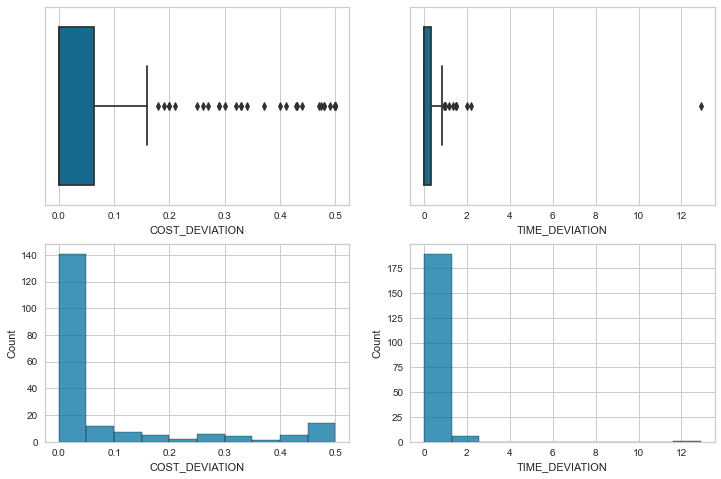

In [142]:
# Dependent variables plot – Competitive bidding projects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.boxplot(x='COST_DEVIATION', data=master_data, ax=axs[0, 0])
sns.boxplot(x='TIME_DEVIATION', data=master_data, ax=axs[0, 1])
sns.histplot(x='COST_DEVIATION', data=master_data, ax=axs[1, 0], bins=10)
sns.histplot(x='TIME_DEVIATION', data=master_data, ax=axs[1, 1], bins=10)
plt.show()

### 3.5.2 Estadísticas descriptivas para variables categóricas

In [143]:
cat_cols = master_data.select_dtypes(include=['object']).columns
for col in cat_cols:
    sort_col = True
    if col == 'YEAR':
        sort_col = False
    print('-'*50)
    print(col)
    print((master_data[col]
           .value_counts(sort=sort_col)
           .reset_index()
           .rename(columns={'index':col, col:'Count'})
           .assign(Percentage=lambda x: np.round(x['Count']/sum(x['Count'])*100, 2))
          )
         )

--------------------------------------------------
CONTRACTOR
   CONTRACTOR  Count  Percentage
0  CONSORTIUM     79       40.10
1     COMPANY     64       32.49
2  INDIVIDUAL     54       27.41
--------------------------------------------------
HIGHEST SCORE
  HIGHEST SCORE  Count  Percentage
0         PRICE    110       55.84
1     TECHNICAL     71       36.04
2         OTHER     16        8.12
--------------------------------------------------
LOWEST_SCORE
        LOWEST_SCORE  Count  Percentage
0              OTHER    162       82.23
1  NATIONAL_INDUSTRY     35       17.77
--------------------------------------------------
YEAR
     YEAR  Count  Percentage
0  Y_2016     30       15.23
1  Y_2017     49       24.87
2  Y_2018     37       18.78
3  Y_2015     65       32.99
4  Y_2019     16        8.12
--------------------------------------------------
IDI_CAT
        IDI_CAT  Count  Percentage
0   OUTSTANDING     60       30.46
1  SATISFACTORY     59       29.95
2           LOW     51 

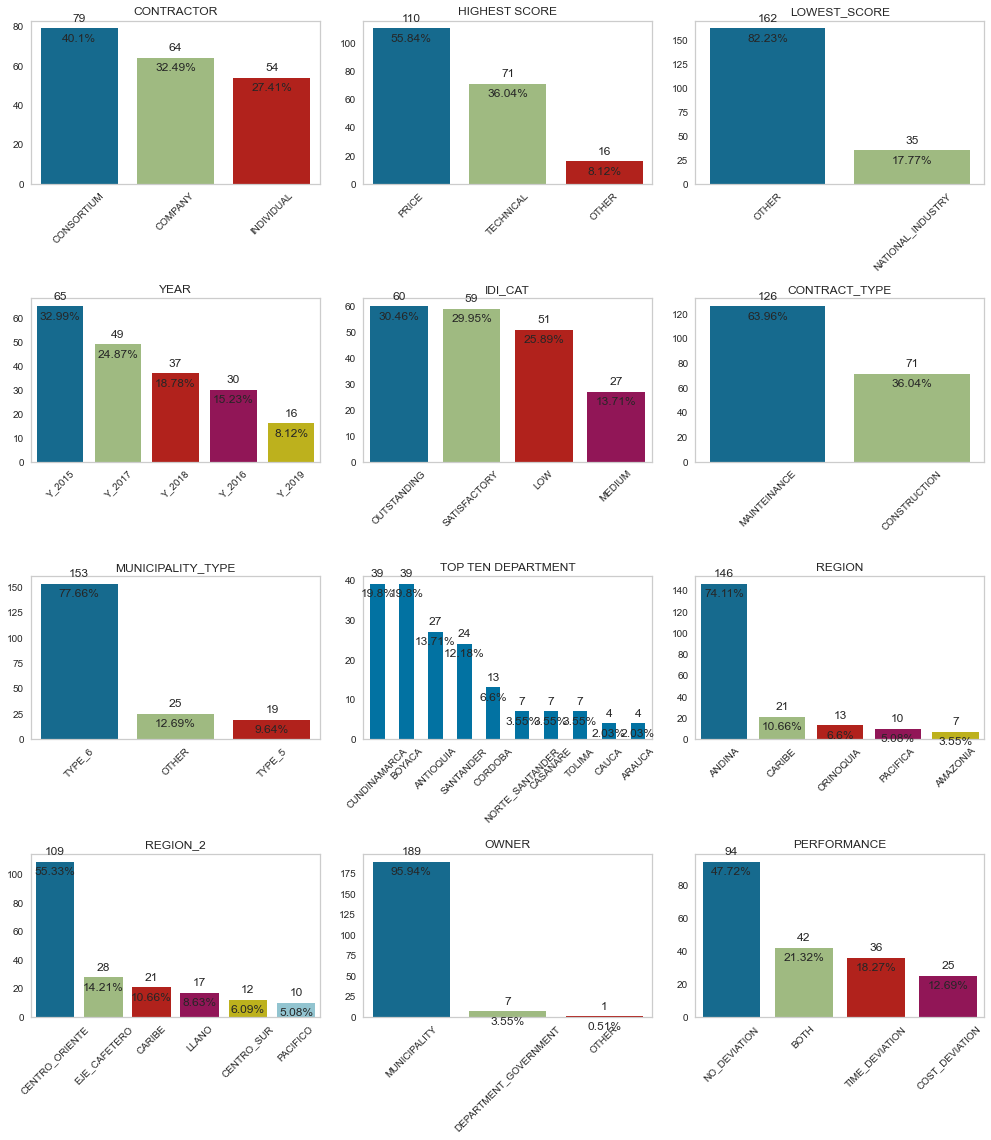

In [144]:
# subplot for categorical values nrows=3, ncols=4
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(14, 16))
for i, col in enumerate(cat_cols):
    if col == 'DEPARTMENT':
        # agregate categories with lower count
        (master_data[col]
        .value_counts(sort=True)
        .head(10)
        .plot(kind='bar', ax=axs[i//3, i%3]))
        axs[i//3, i%3].set_title('TOP TEN ' + col)

    else:
        sns.countplot(x=col, data=master_data, order=master_data[col].value_counts().index, ax=axs[i//3, i%3])
        axs[i//3, i%3].set_title(col)
    
    # add values and percent in barchart
    for p in axs[i//3, i%3].patches:
        axs[i//3, i%3].annotate(
            str(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points')
        axs[i//3, i%3].annotate(
            str(np.round(p.get_height()/sum(master_data[col].value_counts())*100, 2)) + '%',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, -10),
            textcoords='offset points')
        
    # delete grid
    axs[i//3, i%3].grid(False)
    axs[i//3, i%3].set_xticklabels(axs[i//3, i%3].get_xticklabels(), rotation=45)
    axs[i//3, i%3].set_xlabel('')
    # separete plots for each column
    axs[i//3, i%3].set_ylabel('')
plt.tight_layout()
plt.show()

## 4. IDENTIFICATION OF SIGNIFICANT VARIABLES AND ANALYSIS

- Bivariate analysis (Kruska-Wallis test)
- Multivariate analysis (Machine Learning Models and Logistic Regression)
- Comparing results
- Identifying the need for transforming variables
- Evaluating the interest in obtaining the predictive capacity

### 4.1 Bivariate analysis (Kruska-Wallis test and correlation analysis)


In [145]:
# Variables highly Correlated with COST_DEVIATION
correlations[correlations.Var1 == 'COST_DEVIATION'].sort_values(by='rho', ascending=False).head(10)

,Var1,Var2,rho,p-value
20,COST_DEVIATION,ADDITIONAL_COST,0.988513,5.455900e-162
0,COST_DEVIATION,TIME_DEVIATION,0.292881,2.959342e-05
22,COST_DEVIATION,ADDITIONAL_TIME,0.288878,3.839857e-05
25,COST_DEVIATION,IDI,0.186080,8.843451e-03
24,COST_DEVIATION,TIME_SUSPENDED_P,0.157151,2.742545e-02
23,COST_DEVIATION,FINAL_DEADLINE,0.155550,2.906126e-02
21,COST_DEVIATION,FINAL_COST,0.129039,7.073365e-02
13,COST_DEVIATION,PRICE_SCORE,0.099116,1.658306e-01
17,COST_DEVIATION,NUMBER_BIDDERS,0.090207,2.074407e-01
10,COST_DEVIATION,EXPERIENCE_B_VALUE,0.082240,2.505974e-01


In [146]:
# Variables highly Correlated with TIME_DEVIATION
correlations[correlations.Var1 == 'TIME_DEVIATION'].sort_values(by='rho', ascending=False).head(10)

,Var1,Var2,rho,p-value
47,TIME_DEVIATION,ADDITIONAL_TIME,0.981351,1.281052e-141
48,TIME_DEVIATION,FINAL_DEADLINE,0.453164,2.284088e-11
45,TIME_DEVIATION,ADDITIONAL_COST,0.296228,2.373006e-05
49,TIME_DEVIATION,TIME_SUSPENDED_P,0.238204,7.496966e-04
37,TIME_DEVIATION,PROJECT_INTENSITY,0.226560,1.367509e-03
46,TIME_DEVIATION,FINAL_COST,0.179490,1.161069e-02
50,TIME_DEVIATION,IDI,0.155605,2.900367e-02
40,TIME_DEVIATION,NATIONAL_INDUSTRY_SCORE,0.148998,3.664804e-02
31,TIME_DEVIATION,DEBT_INDEX_B,0.147494,3.860926e-02
42,TIME_DEVIATION,NUMBER_BIDDERS,0.139034,5.135569e-02


In [147]:
# select categorical columns
cat_cols = master_data.select_dtypes(include=['object']).columns
for var in cat_cols:
    print("-"*50)
    print("Estadisticas comparativas por la variable {}".format(var))
    print((master_data
            .loc[master_data.COST_DEVIATION >= 0, [var,"COST_DEVIATION"]]
            .groupby(var)
            .describe()
            .T))

--------------------------------------------------
Estadisticas comparativas por la variable CONTRACTOR
CONTRACTOR              COMPANY  CONSORTIUM  INDIVIDUAL
COST_DEVIATION count  64.000000   79.000000   54.000000
               mean    0.090043    0.058908    0.096481
               std     0.163081    0.129025    0.166622
               min     0.000000    0.000000    0.000000
               25%     0.000000    0.000000    0.000000
               50%     0.000000    0.000000    0.000000
               75%     0.072500    0.020000    0.137500
               max     0.500000    0.500000    0.500000
--------------------------------------------------
Estadisticas comparativas por la variable HIGHEST SCORE
HIGHEST SCORE             OTHER       PRICE  TECHNICAL
COST_DEVIATION count  16.000000  110.000000  71.000000
               mean    0.049021    0.095671   0.060823
               std     0.126673    0.162259   0.137467
               min     0.000000    0.000000   0.000000
          

In [148]:
# Kruskal-Wallis test for all categorical variables
print("Prueba de Kruskal-Wallis para todas las variables categóricas con respecto a la desviación en costo")
y_var = "COST_DEVIATION"
kw_test = []
for x_var in cat_cols:
    temp = [group[y_var].values for name, group in master_data.groupby(x_var)]
    K, p = stats.kruskal(*temp)
    kw_test.append((y_var, x_var, K, p, p < 0.05))
kw_cost = pd.DataFrame(kw_test, columns=['Dependent', 'Independent', 'K', 'p-value', 'Significant'])
kw_cost.sort_values(by='p-value', ascending=True)

Prueba de Kruskal-Wallis para todas las variables categóricas con respecto a la desviación en costo


,Dependent,Independent,K,p-value,Significant
11,COST_DEVIATION,PERFORMANCE,185.225161,6.561202e-40,True
6,COST_DEVIATION,MUNICIPALITY_TYPE,9.709419,7.791597e-03,True
8,COST_DEVIATION,REGION,8.153276,8.612214e-02,False
4,COST_DEVIATION,IDI_CAT,6.423278,9.273783e-02,False
9,COST_DEVIATION,REGION_2,7.966883,1.580702e-01,False
7,COST_DEVIATION,DEPARTMENT,28.674305,2.326296e-01,False
5,COST_DEVIATION,CONTRACT_TYPE,1.284136,2.571314e-01,False
0,COST_DEVIATION,CONTRACTOR,2.578766,2.754407e-01,False
1,COST_DEVIATION,HIGHEST SCORE,2.103797,3.492739e-01,False
3,COST_DEVIATION,YEAR,4.072762,3.962482e-01,False


In [149]:
# Kruskal-Wallis test for all categorical variables
# print("Prueba de Kruskal-Wallis para todas las variables categóricas con respecto a la desviación en costo")
y_var = "TIME_DEVIATION"
kw_test = []
for x_var in cat_cols:
    temp = [group[y_var].values for name, group in master_data.groupby(x_var)]
    K, p = stats.kruskal(*temp)
    kw_test.append((y_var, x_var, K, p, p < 0.05))
kw_cost = pd.DataFrame(kw_test, columns=['Dependent', 'Independent', 'K', 'p-value', 'Significant'])
kw_cost.sort_values(by='p-value', ascending=True)

,Dependent,Independent,K,p-value,Significant
11,TIME_DEVIATION,PERFORMANCE,180.613105,6.502226e-39,True
4,TIME_DEVIATION,IDI_CAT,9.088929,2.813159e-02,True
0,TIME_DEVIATION,CONTRACTOR,5.479938,6.457235e-02,False
6,TIME_DEVIATION,MUNICIPALITY_TYPE,4.079230,1.300788e-01,False
10,TIME_DEVIATION,OWNER,3.510146,1.728946e-01,False
7,TIME_DEVIATION,DEPARTMENT,29.851905,1.897088e-01,False
2,TIME_DEVIATION,LOWEST_SCORE,0.596193,4.400344e-01,False
3,TIME_DEVIATION,YEAR,3.604302,4.621972e-01,False
5,TIME_DEVIATION,CONTRACT_TYPE,0.252684,6.151916e-01,False
1,TIME_DEVIATION,HIGHEST SCORE,0.295095,8.628212e-01,False


In [150]:
#master_data.to_csv('data/cleaned_data.csv', index=False)

## 4.2 Multivariate analysis (Machine Learning Models and Logistic Regression)

### 4.2.1 Logistic Regression Analysis for cost deviation

In [151]:
import statsmodels.api as sm

In [152]:
master_data = master_data.loc[master_data.OWNER != 'OTHER',]
master_data.shape

(196, 36)

In [153]:
# Function to fit logistic model regression
def logit_model(data, X, y):
    X_data = data[X].copy()
    if('NUMBER_BIDDERS' in X):
        X_data['ONE_BIDDER'] = [1 if i == 1 else 0 for i in X_data['NUMBER_BIDDERS']]
    X_data = pd.get_dummies(X_data, drop_first=True)
    y_data = [1 if i > 0 else 0 for i in data[y]]
    X_data = sm.add_constant(X_data)
    model_fit = sm.Logit(y_data, X_data).fit()
    print(model_fit.summary())
    return model_fit

##### Project Initiation Logit Model

In [154]:
# Variable classification by phase of project
initiation_cols = ['CONTRACT_TYPE', # Modify in the dictionary, this appear how project type
                      'OWNER',
                      'REGION',
                      'MUNICIPALITY_TYPE',
                      'YEAR', # This is control variable, not useful for classification
                      'ESTIMATED_COST',
                      'ORIGINAL_DEADLINE',
                      'PROJECT_INTENSITY',
                      'TIME_STUDIES_CONTRACT',
                      'IDI',
                      'IDI_CAT']

In [155]:
cost_model1 = logit_model(data=master_data, X=initiation_cols, y='COST_DEVIATION')

Optimization terminated successfully.
         Current function value: 0.578203
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  196
Model:                          Logit   Df Residuals:                      175
Method:                           MLE   Df Model:                           20
Date:                Mon, 22 Aug 2022   Pseudo R-squ.:                 0.09972
Time:                        21:47:29   Log-Likelihood:                -113.33
converged:                       True   LL-Null:                       -125.88
Covariance Type:            nonrobust   LLR p-value:                    0.1974
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.6915      2.894     -0.930      0.352      

##### Project Planning

In [156]:
# Variable classification by phase of project
# Include working capital and net equity how dummy variables, 1 if yes, 0 if no
planning_cols = ['CONTRACTOR',
                    'AWARD_GROWTH',
                    'ADVANCED_PAYMENT',
                    'EXPERIENCE_B_VALUE', 
                    'K_CONTRACTING_B_VALUE',
                    'LIQUIDITY_INDEX_B',
                    'DEBT_INDEX_B', 
                    'INTEREST_COVERAGE_RATIO_B',
                    'ROE_B',
                    'NUMBER_BIDDERS', # Include dummy variable 1 if the tender has 1 bidder, 0 the tender has more than 1 bidder
                    'PRICE_SCORE',
                    'TECHNICAL_SCORE',
                    'NATIONAL_INDUSTRY_SCORE',
                    #'OTHER_SCORE',
                    'HIGHEST SCORE',
                    'LOWEST_SCORE']

In [157]:
cost_model2 = logit_model(data=master_data, X=planning_cols, y='COST_DEVIATION')

Optimization terminated successfully.
         Current function value: 0.565150
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  196
Model:                          Logit   Df Residuals:                      177
Method:                           MLE   Df Model:                           18
Date:                Mon, 22 Aug 2022   Pseudo R-squ.:                  0.1200
Time:                        21:47:30   Log-Likelihood:                -110.77
converged:                       True   LL-Null:                       -125.88
Covariance Type:            nonrobust   LLR p-value:                   0.03535
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         6.9744      2.779      2.510      0.012       1.

#### All variables

In [158]:
cost_model3 = logit_model(data=master_data, X=initiation_cols + planning_cols, y='COST_DEVIATION')

Optimization terminated successfully.
         Current function value: 0.498740
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  196
Model:                          Logit   Df Residuals:                      157
Method:                           MLE   Df Model:                           38
Date:                Mon, 22 Aug 2022   Pseudo R-squ.:                  0.2234
Time:                        21:47:32   Log-Likelihood:                -97.753
converged:                       True   LL-Null:                       -125.88
Covariance Type:            nonrobust   LLR p-value:                   0.02849
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          5.2756      4.523      1.166      0.243      

#### Summary of all models

In [159]:
summary_cost_m1 = cost_model1.params.reset_index().rename(columns={'index':'Variable',0:'Coef M1'})
summary_cost_m1['Std Error M1'] = cost_model1.bse.values
summary_cost_m1['p-value M1'] = cost_model1.pvalues.values
summary_cost_m1.loc[summary_cost_m1['p-value M1'] < 0.1,]

,Variable,Coef M1,Std Error M1,p-value M1
6,CONTRACT_TYPE_MAINTEINANCE,0.715041,0.387963,0.06532


In [160]:
summary_cost_m2 = cost_model2.params.reset_index().rename(columns={'index':'Variable',0:'Coef M2'})
summary_cost_m2['Std Error M2'] = cost_model2.bse.values
summary_cost_m2['p-value M2'] = cost_model2.pvalues.values
summary_cost_m2.loc[summary_cost_m2['p-value M2'] < 0.1,]

,Variable,Coef M2,Std Error M2,p-value M2
0,const,6.974413,2.778938,0.012082
2,ADVANCED_PAYMENT,-1.872752,1.014292,0.064839
5,LIQUIDITY_INDEX_B,0.006697,0.003363,0.046447
9,NUMBER_BIDDERS,-0.339242,0.170823,0.047041
10,PRICE_SCORE,-7.388474,3.794504,0.051517
11,TECHNICAL_SCORE,-9.481486,3.895803,0.014943
13,ONE_BIDDER,-1.628721,0.540017,0.002561
18,LOWEST_SCORE_OTHER,1.735070,0.999873,0.082689


In [161]:
summary_cost_m3 = cost_model3.params.reset_index().rename(columns={'index':'Variable',0:'Coef M3'})
summary_cost_m3['Std Error M3'] = cost_model3.bse.values
summary_cost_m3['p-value M3'] = cost_model3.pvalues.values
summary_cost_m3.loc[summary_cost_m3['p-value M3'] < 0.1,]

,Variable,Coef M3,Std Error M3,p-value M3
10,LIQUIDITY_INDEX_B,0.009014,0.003797,0.017592
12,INTEREST_COVERAGE_RATIO_B,-0.006404,0.003696,0.083149
14,NUMBER_BIDDERS,-0.410474,0.181399,0.023646
15,PRICE_SCORE,-11.376933,4.621945,0.013836
16,TECHNICAL_SCORE,-12.753688,4.762809,0.007411
17,NATIONAL_INDUSTRY_SCORE,-12.328398,7.057023,0.080643
18,ONE_BIDDER,-1.694645,0.615822,0.005926
19,CONTRACT_TYPE_MAINTEINANCE,0.804715,0.438310,0.066365
30,YEAR_Y_2019,1.723258,1.026335,0.093144
36,HIGHEST SCORE_PRICE,1.831167,0.949159,0.053700


### 4.2.2 Machine Learning for predicting the cost deviation

In [162]:
# Macine learning libraries
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

In [163]:
del_columns = ['TIME_DEVIATION', 'FINAL_COST', 'ADDITIONAL_TIME', 'FINAL_DEADLINE', 'TIME_SUSPENDED_P', 'REGION_2','PERFORMANCE','DEPARTMENT','NUMBER_OF_CONTRACTS']
df_cost_cat = master_data.reset_index().drop(del_columns, axis=1)

In [164]:
# Create X and y = COST_DEVIATION
X = df_cost_cat.drop('COST_DEVIATION', axis=1)
y = [1 if i > 0 else 0 for i in df_cost_cat['COST_DEVIATION']]

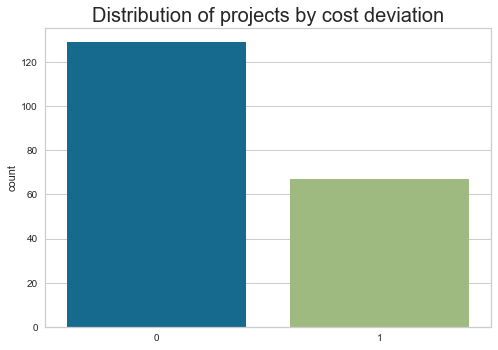

In [165]:
sns.countplot(x=y)
plt.title('Distribution of projects by cost deviation', fontsize=20)
plt.show()

In [166]:
# 1. Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Prepare pipeline
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_exclude=['object'])),
                                             (OneHotEncoder(), make_column_selector(dtype_include=['object'])),
                                              remainder='passthrough')

# 3. Models
models_estimator = [LogisticRegression(solver='lbfgs', max_iter=1000),
        RidgeClassifier(alpha=0.5),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt'),
        ExtraTreeClassifier(max_depth=5, random_state=0),
        AdaBoostClassifier(n_estimators=100),
        GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        LinearSVC(max_iter=100),
        SVC(kernel='rbf', gamma=0.1, C=10)]
models_names = ['Logistic Regression', 'Ridge', 'Decision Tree', 'Random Forest', 'Extra Tree', 
                'AdaBoost', 'Gradient Boosting', 'Xgboost', 'Linear SVC', 'SVC']

scores_models = []
for model, name in zip(models_estimator, models_names):
    pipe_model = make_pipeline(column_transformer, model)
    pipe_model.fit(X_train, y_train)
    predictions = pipe_model.predict(X_test)
    scores_models.append((name, accuracy_score(y_test, predictions), roc_auc_score(y_test, predictions),
                          precision_score(y_test, predictions), recall_score(y_test, predictions), 
                          f1_score(y_test, predictions)))

# Create a dataframe with the scores
scores_df = pd.DataFrame(scores_models, columns=['Model', 'Accuracy', 'ROC_AUC','Precision', 'Recall', 'F1 Score'])
scores_df.sort_values(by=['F1 Score'], ascending=False, inplace=True)
scores_df

/Users/hfelizzola/opt/anaconda3/envs/pycaret-autoML/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,Model,Accuracy,ROC_AUC,Precision,Recall,F1 Score
6,Gradient Boosting,0.644068,0.544079,0.416667,0.263158,0.322581
8,Linear SVC,0.576271,0.494079,0.312500,0.263158,0.285714
4,Extra Tree,0.644068,0.530263,0.400000,0.210526,0.275862
9,SVC,0.627119,0.517763,0.363636,0.210526,0.266667
3,Random Forest,0.644068,0.516447,0.375000,0.157895,0.222222
5,AdaBoost,0.491525,0.417763,0.210526,0.210526,0.210526
2,Decision Tree,0.576271,0.466447,0.250000,0.157895,0.193548
7,Xgboost,0.559322,0.453947,0.230769,0.157895,0.187500
0,Logistic Regression,0.491525,0.403947,0.176471,0.157895,0.166667
1,Ridge,0.474576,0.391447,0.166667,0.157895,0.162162


In [167]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, PrecisionRecallCurve

In [168]:
# Scaler X 
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_cols])
X_scaled = pd.DataFrame(X_scaled, columns=num_cols)
# OneHotEncoder X
cat_cols = X.select_dtypes(include=['object']).columns
X_cat_encoded = pd.get_dummies(X[cat_cols])
# Concatenate X
X_prep = pd.concat([X_scaled, X_cat_encoded], axis=1)

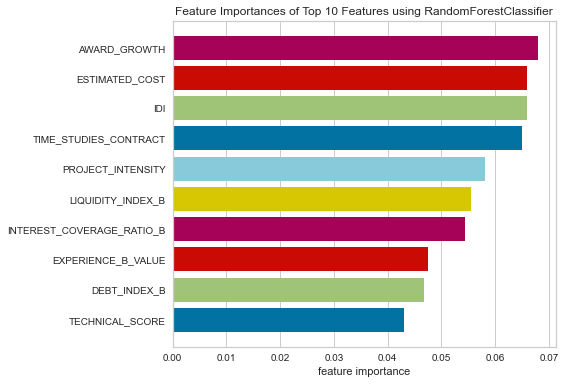

<AxesSubplot:title={'center':'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [169]:
# AdaBoost
model =  RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt')
viz = FeatureImportances(model, orient='h', topn=10, relative=False)
viz.fit(X_prep, y)
viz.show()

### 4.2.3 Logistic Regression Analysis for time deviation

##### Project Initiation Logit Model

In [170]:
time_model1 = logit_model(data=master_data, X=initiation_cols, y='TIME_DEVIATION')

Optimization terminated successfully.
         Current function value: 0.607291
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  196
Model:                          Logit   Df Residuals:                      175
Method:                           MLE   Df Model:                           20
Date:                Mon, 22 Aug 2022   Pseudo R-squ.:                 0.09361
Time:                        21:47:44   Log-Likelihood:                -119.03
converged:                       True   LL-Null:                       -131.32
Covariance Type:            nonrobust   LLR p-value:                    0.2177
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.9299      2.589     -0.359      0.719      

##### Project Planning

In [171]:
time_model2 = logit_model(data=master_data, X=planning_cols, y='TIME_DEVIATION')

Optimization terminated successfully.
         Current function value: 0.605140
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  196
Model:                          Logit   Df Residuals:                      177
Method:                           MLE   Df Model:                           18
Date:                Mon, 22 Aug 2022   Pseudo R-squ.:                 0.09682
Time:                        21:47:45   Log-Likelihood:                -118.61
converged:                       True   LL-Null:                       -131.32
Covariance Type:            nonrobust   LLR p-value:                    0.1136
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         4.3100      2.639      1.633      0.102      -0.

#### All variables

In [172]:
time_model3 = logit_model(data=master_data, X=initiation_cols + planning_cols, y='TIME_DEVIATION')

Optimization terminated successfully.
         Current function value: 0.544368
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  196
Model:                          Logit   Df Residuals:                      157
Method:                           MLE   Df Model:                           38
Date:                Mon, 22 Aug 2022   Pseudo R-squ.:                  0.1875
Time:                        21:47:46   Log-Likelihood:                -106.70
converged:                       True   LL-Null:                       -131.32
Covariance Type:            nonrobust   LLR p-value:                    0.1045
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          6.3989      4.235      1.511      0.131      

#### Summary of all models

In [173]:
summary_time_m1 = time_model1.params.reset_index().rename(columns={'index':'Variable',0:'Coef M1'})
summary_time_m1['Std Error M1'] = time_model1.bse.values
summary_time_m1['p-value M1'] = time_model1.pvalues.values
summary_time_m1.loc[summary_time_m1['p-value M1'] < 0.1,]

,Variable,Coef M1,Std Error M1,p-value M1
12,MUNICIPALITY_TYPE_TYPE_5,1.579425,0.827442,0.056287
14,YEAR_Y_2016,1.107783,0.570142,0.052017
15,YEAR_Y_2017,0.770361,0.453548,0.089410


In [174]:
summary_time_m2 = time_model2.params.reset_index().rename(columns={'index':'Variable',0:'Coef M2'})
summary_time_m2['Std Error M2'] = time_model2.bse.values
summary_time_m2['p-value M2'] = time_model2.pvalues.values
summary_time_m2.loc[summary_time_m2['p-value M2'] < 0.1,]

,Variable,Coef M2,Std Error M2,p-value M2
10,PRICE_SCORE,-6.639828,3.586838,0.064146
11,TECHNICAL_SCORE,-6.728785,3.616487,0.062803


In [175]:
summary_time_m3 = time_model3.params.reset_index().rename(columns={'index':'Variable',0:'Coef M3'})
summary_time_m3['Std Error M3'] = time_model3.bse.values
summary_time_m3['p-value M3'] = time_model3.pvalues.values
summary_time_m3.loc[summary_time_m3['p-value M3'] < 0.1,]

,Variable,Coef M3,Std Error M3,p-value M3
15,PRICE_SCORE,-9.407146,4.108490,0.022040
16,TECHNICAL_SCORE,-8.731952,4.194675,0.037372
23,REGION_ORINOQUIA,-2.405728,1.293760,0.062958
27,YEAR_Y_2016,1.330629,0.630493,0.034819
34,CONTRACTOR_CONSORTIUM,0.832724,0.452383,0.065658


### 4.2.4 Machine Learning for predicting the time deviation

In [176]:
del_columns = ['COST_DEVIATION', 'FINAL_COST', 'ADDITIONAL_TIME', 'FINAL_DEADLINE', 'TIME_SUSPENDED_P', 'REGION_2','PERFORMANCE','DEPARTMENT','NUMBER_OF_CONTRACTS']
df_time_cat = master_data.reset_index().drop(del_columns, axis=1)

In [177]:
# Create X and y = TIME_DEVIATION
X = df_time_cat.drop('TIME_DEVIATION', axis=1)
y = [1 if i > 0 else 0 for i in df_time_cat['TIME_DEVIATION']]

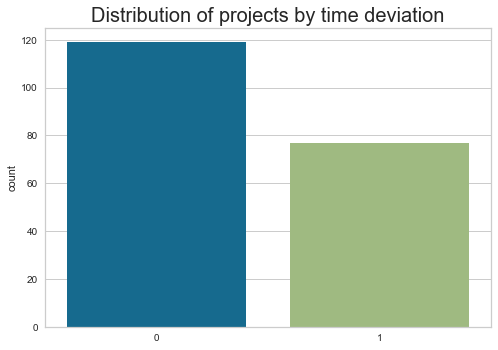

In [178]:
sns.countplot(x=y)
plt.title('Distribution of projects by time deviation', fontsize=20)
plt.show()

In [179]:
# 1. Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Prepare pipeline
column_transformer = make_column_transformer((StandardScaler(), make_column_selector(dtype_exclude=['object'])),
                                             (OneHotEncoder(), make_column_selector(dtype_include=['object'])),
                                              remainder='passthrough')

# 3. Models
models_estimator = [LogisticRegression(solver='lbfgs', max_iter=1000),
        RidgeClassifier(alpha=0.5),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt'),
        ExtraTreeClassifier(max_depth=5, random_state=0),
        AdaBoostClassifier(n_estimators=100),
        GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1),
        LinearSVC(max_iter=100),
        SVC(kernel='rbf', gamma=0.1, C=10)]
models_names = ['Logistic Regression', 'Ridge', 'Decision Tree', 'Random Forest', 'Extra Tree', 
                'AdaBoost', 'Gradient Boosting', 'Xgboost', 'Linear SVC', 'SVC']

scores_models = []
for model, name in zip(models_estimator, models_names):
    pipe_model = make_pipeline(column_transformer, model)
    pipe_model.fit(X_train, y_train)
    predictions = pipe_model.predict(X_test)
    scores_models.append((name, accuracy_score(y_test, predictions), roc_auc_score(y_test, predictions),
                          precision_score(y_test, predictions), recall_score(y_test, predictions), 
                          f1_score(y_test, predictions)))

# Create a dataframe with the scores
scores_df = pd.DataFrame(scores_models, columns=['Model', 'Accuracy', 'ROC_AUC','Precision', 'Recall', 'F1 Score'])
scores_df.sort_values(by=['F1 Score'], ascending=False, inplace=True)
scores_df

/Users/hfelizzola/opt/anaconda3/envs/pycaret-autoML/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


,Model,Accuracy,ROC_AUC,Precision,Recall,F1 Score
8,Linear SVC,0.677966,0.643484,0.550000,0.523810,0.536585
3,Random Forest,0.661017,0.630326,0.523810,0.523810,0.523810
1,Ridge,0.644068,0.617168,0.500000,0.523810,0.511628
9,SVC,0.576271,0.585840,0.433333,0.619048,0.509804
0,Logistic Regression,0.661017,0.619674,0.526316,0.476190,0.500000
2,Decision Tree,0.593220,0.577694,0.440000,0.523810,0.478261
5,AdaBoost,0.593220,0.577694,0.440000,0.523810,0.478261
7,Xgboost,0.593220,0.577694,0.440000,0.523810,0.478261
6,Gradient Boosting,0.593220,0.567043,0.434783,0.476190,0.454545
4,Extra Tree,0.661017,0.577068,0.545455,0.285714,0.375000


#### Visualization the validation for the Random Forest

In [180]:
# Scaler X 
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_cols])
X_scaled = pd.DataFrame(X_scaled, columns=num_cols)
# OneHotEncoder X
cat_cols = X.select_dtypes(include=['object']).columns
X_cat_encoded = pd.get_dummies(X[cat_cols])
# Concatenate X
X_prep = pd.concat([X_scaled, X_cat_encoded], axis=1)

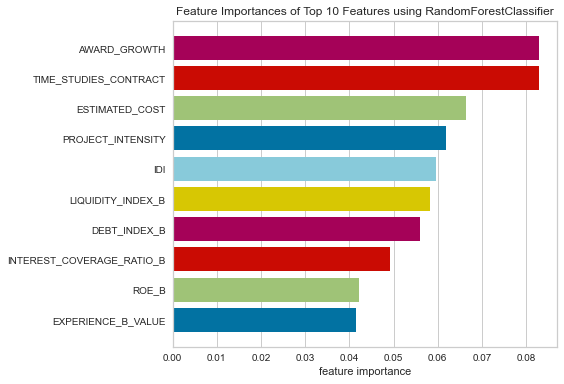

<AxesSubplot:title={'center':'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [181]:
# AdaBoost
model =  RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_features='sqrt')
viz = FeatureImportances(model, orient='h', topn=10, relative=False)
viz.fit(X_prep, y)
viz.show()